In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [132]:
# Specify the first year we consider in our analysis
START_YEAR = 1970
# Specify career len to export file for
CAREER_LENGTH = 10
# Specify how long is the early career. Impacts which papers we take into account for early productivity and quality
EARLY_CAREER_LEN = 3
# For early career worak, when do we stop counting citations. Impacts recognition
RECOGNITION_CUT_OFF = 5
# Success after 15 years. Impacts when we stop counting citations
SUCCESS_CUTOFF = 15

## 1. Load data

In [133]:
authorPublicationData = pd.read_csv('./data/author_publications_2017_asiansAsNone.txt')
print(authorPublicationData.shape)
authorPublicationData.head()

(9471668, 3)


,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


In [134]:
authorCitationsData = pd.read_csv('./data/citations_2017_asiansAsNone.txt')
authorCitationsData.head()

,id1,id2,year
0,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,5065f1e8-0e2e-4e20-9866-2b5067d321dc,1990
1,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,cf862fd8-9204-4e44-9639-2d067c247539,1990
2,1fcd3d7f-1bb7-4347-914e-e23adb1e1a59,f19127f8-3d3a-4a9e-9580-c1d3e1e05141,1990
3,03b1d66a-b1fc-4d99-9904-9405695cc2ae,09991de0-c00f-49cf-a88a-6515943b0843,1994
4,03b1d66a-b1fc-4d99-9904-9405695cc2ae,156173f6-35eb-44f6-bc75-7c205153b6f0,1994


In [135]:
print('Authors# - ',authorPublicationData['author'].nunique())
print('Years# - ',authorPublicationData['year'].nunique())
print('Publications# - ',authorPublicationData['pub_id'].nunique())

Authors# -  1704919
Years# -  83
Publications# -  3078230


## 2. Criteria for author removal

In [136]:
groupByAuthor = authorPublicationData.groupby(['author'])

groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

In [137]:
authorGroupedData = groupByAuthorMinYearData.to_frame(name='start_year')
authorGroupedData['end_year'] = groupByAuthorMaxYearData
authorGroupedData['num_pub'] = groupByAuthorCountPublicationsData
authorGroupedData = authorGroupedData.reset_index()
print('Total rows -                ', authorGroupedData.shape)

authorGroupedData = authorGroupedData[authorGroupedData["start_year"] >= START_YEAR]
print('After removing all < 1970 - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.drop_duplicates()
print('After removing duplicates - ', authorGroupedData.shape)

authorGroupedData = authorGroupedData.dropna(how='any')
print("After droping na -          ", authorGroupedData.shape)

authorGroupedData.head()

Total rows -                 (1704919, 4)
After removing all < 1970 -  (1699352, 4)
After removing duplicates -  (1699352, 4)
After droping na -           (1699352, 4)


,author,start_year,end_year,num_pub
0,'maseka lesaoana,2001,2015,2
1,(max) zong-ming cheng,2009,2011,2
2,(zhou) bryan bai,2011,2012,2
3,a aart blokhuis,1992,2005,2
4,a ahrabian,2017,2017,1


In [138]:
# Adding one here to have career length be at least one. So 3 years career means year1, year2, year3.
authorGroupedData["career_length"] = authorGroupedData['end_year'] - authorGroupedData['start_year'] + 1

### Remove authors by career length

In [139]:
authorGroupedData = authorGroupedData[authorGroupedData['career_length'] >= CAREER_LENGTH]

### Career length distribution

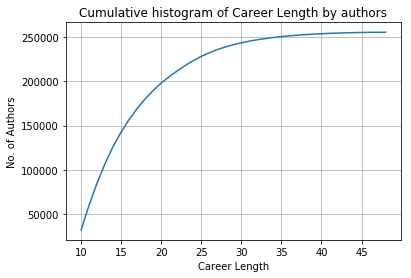

In [140]:
careerLengthDist = authorGroupedData.groupby(["career_length"])['author'].count()
temp = careerLengthDist.cumsum()  
ax = temp.plot(grid=True, title='Cumulative histogram of Career Length by authors')
ax.set_xlabel('Career Length')
ax.set_ylabel('No. of Authors')

plt.show()

In [141]:
credible_authors = authorGroupedData

### Label authors inactive for 10 years

In [142]:
combined_pubs = authorPublicationData.merge(credible_authors[['author', 'start_year']], on='author', how='inner')

print(combined_pubs.head())

In [143]:
combined_pubs_15_y = combined_pubs[combined_pubs.year <= combined_pubs.start_year + 15]

In [144]:
combined_pubs_15_y = combined_pubs_15_y.groupby('author')['year'].apply(
    lambda x: [nxt - prev for prev, nxt in zip(sorted(x), sorted(x)[1:])])

In [145]:
combined_pubs_15_y = combined_pubs_15_y.reset_index()

In [146]:
combined_pubs_15_y.head()

,author,year
0,'maseka lesaoana,[14]
1,a aart blokhuis,[13]
2,a min tjoa,"[7, 4, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
3,a-imam al-sammak,"[13, 1]"
4,a-xing zhu,"[5, 3, 0, 1, 0, 2, 0, 0, 1, 1, 0, 1]"


In [147]:
combined_pubs_15_y['max_absence'] = combined_pubs_15_y['year'].apply(lambda x: 15 if x==[] else max(x))

In [148]:
combined_pubs_15_y['avg_absence'] = combined_pubs_15_y['year'].apply(lambda x: 15 if x==[] else np.mean(x))

In [149]:
combined_pubs_15_y.head(10)

,author,year,max_absence,avg_absence
0,'maseka lesaoana,[14],14,14.000000
1,a aart blokhuis,[13],13,13.000000
2,a min tjoa,"[7, 4, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]",7,1.071429
3,a-imam al-sammak,"[13, 1]",13,7.000000
4,a-xing zhu,"[5, 3, 0, 1, 0, 2, 0, 0, 1, 1, 0, 1]",5,1.166667
5,a. a. (louis) beex,"[0, 4, 0, 1, 1, 0, 6, 3]",6,1.875000
6,a. a. abouelsoud,"[0, 2]",2,1.000000
7,a. a. badr,"[1, 9]",9,5.000000
8,a. a. ball,"[2, 7, 4]",7,4.333333
9,a. a. c. c. pais,"[9, 0, 2, 1, 1]",9,2.600000


In [150]:
credible_authors = credible_authors.merge(combined_pubs_15_y[['author', 'max_absence', 'avg_absence']], on='author', how='left')

In [151]:
credible_authors.head()

,author,start_year,end_year,num_pub,career_length,max_absence,avg_absence
0,'maseka lesaoana,2001,2015,2,15,14,14.000000
1,a aart blokhuis,1992,2005,2,14,13,13.000000
2,a min tjoa,1979,2017,191,39,7,1.071429
3,a-imam al-sammak,1992,2006,3,15,13,7.000000
4,a-xing zhu,1998,2017,22,20,5,1.166667


In [152]:
credible_authors['dropped_after_10'] = credible_authors['max_absence'].apply(lambda x: False if x <= 10 else True)

In [153]:
credible_authors.max_absence.value_counts(dropna=False)

2     40545
3     38947
4     32649
5     25764
6     20204
7     15758
1     15489
9     12766
8     12594
15    12090
10     9437
11     6911
12     5096
13     4020
14     2890
0       536
Name: max_absence, dtype: int64

In [154]:
credible_authors.shape

(255696, 8)

In [155]:
credible_authors['dropped_after_10'].value_counts()

False    224689
True      31007
Name: dropped_after_10, dtype: int64

### Gender

In [156]:
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')


credible_authors = credible_authors.merge(gender, left_on='author', right_on='name', how='left')

credible_authors.drop('name', axis=1, inplace=True)

credible_authors.head()

credible_authors.gender.value_counts()

m       129909
none     98303
f        27484
Name: gender, dtype: int64

### Save filtered data about authors

In [157]:
credible_authors.to_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv',
                    index=False, encoding='utf-8')

In [158]:
# Quick load
# credible_authors = pd.read_csv('data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


### Remove author from publications

In [159]:
print(authorPublicationData.shape)

(9471668, 3)


In [160]:
authorPublicationData_cleaned = authorPublicationData.loc[authorPublicationData.author.isin(credible_authors.author)]

In [161]:
print(authorPublicationData_cleaned.shape)

(5898126, 3)


In [162]:
authorPublicationData_cleaned.to_csv('derived-data/author-publications-atleast-'+ str(CAREER_LENGTH)+'-year.csv', index=False)

In [163]:
# Quick load
# authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+ str(CAREER_LENGTH)+'-year.csv')

## 3. Generate a new citation network

### Generate Author->Paper network

In [164]:
# We need data about how many times an author has been cited
# For every authors publication, i merge all citations
final_citation_count_from_ids = authorPublicationData.merge(authorCitationsData, left_on='pub_id', 
                                                            right_on='id2', how='inner', suffixes=('_pub', '_cit'))

In [165]:
final_citation_count_from_ids.drop_duplicates(inplace=True)

#### Remove errors in citation data (years published vs years cited)

In [166]:
# Published before cited - NORMAL
print(final_citation_count_from_ids.shape)
num_normal = final_citation_count_from_ids[final_citation_count_from_ids.year_pub <= final_citation_count_from_ids.year_cit].shape
print(num_normal)

(75912535, 6)
(75392625, 6)


In [167]:
# Published after cited - WRONG
num_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].shape
print(num_wrong)

(519910, 6)


In [168]:
print("Percentage of citations to be removed: ", num_wrong[0]*100/(num_normal[0]+num_wrong[0]))
print("Less than one percent")

Percentage of citations to be removed:  0.6848803033649186
Less than one percent


In [169]:
cit_wrong_df = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit]

In [170]:
cit_wrong = final_citation_count_from_ids[final_citation_count_from_ids.year_pub > final_citation_count_from_ids.year_cit].index

In [171]:
final_citation_count_from_ids.drop(cit_wrong, inplace=True)

assert num_normal[0] == final_citation_count_from_ids.shape[0], "The number of citations doesnt match"

In [172]:
final_citation_count_from_ids.columns

Index(['author', 'year_pub', 'pub_id', 'id1', 'id2', 'year_cit'], dtype='object')

#### Save

In [173]:
# final_citation_count_from_ids.to_csv('./data/authors_cited_by_papers_2017_asiansAsNone_by_daniel.txt',
#                                      columns=['author', 'year_pub', 'pub_id', 'id1', 'year_cit'], index=False)

final_citation_count_from_ids[['author', 'id1', 'id2', 'year_cit']].drop_duplicates().to_csv('derived-data/author-paper-citations-cleaned.csv', 
                                                                                   index=False)

# final_citation_count_from_ids.drop_duplicates(subset=['author_cited', 'pub_id_cited', 'pub_id_citing', 'author_citing'],
#                                               inplace=True)

In [174]:
# Quick load
# final_citation_count_from_ids = pd.read_csv('derived-data/paper-paper-citations-cleaned.csv')

In [175]:
# drop duplicates on id1,id2 because we only care about paper->paper citations
paper_citation_count = final_citation_count_from_ids.drop_duplicates(subset=['id1', 'id2']).groupby('id2')['id1'].count()
paper_citation_count.to_csv('derived-data/paper-citation-count.csv')

Its important to keep using this file for citations. As it has bad entries removed

### Generate Author->Author network

In [176]:
# # To generate an author->author citation network
# # For every citation an author received, merge in all the authors that cited him
# # TODO Should we be filtering citations? Do we include them all? We do drop ones cited before published
# final_citation_count_from_ids = final_citation_count_from_ids.merge(authorPublicationData, left_on='id1', 
#                                                                     right_on='pub_id', how='left', suffixes=('_cited', '_citing'))
# final_citation_count_from_ids.to_csv('./derived-data/author-author-citations.csv',
#                                      columns=['author_cited', 'author_citing', 'year_cit'], index=False)

In [177]:
final_citation_count_from_ids.head()

,author,year_pub,pub_id,id1,id2,year_cit
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,16870052-7e2e-4bbc-beeb-21e493bea221,001c58d3-26ad-46b3-ab3a-c1e557d16821,2015
18,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,001c8744-73c4-4b04-9364-22d31a10dbf1,2013
19,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,ae0b4e3d-305d-4fb8-9847-60dcc9a9ec44,001c8744-73c4-4b04-9364-22d31a10dbf1,2014
20,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,001c8744-73c4-4b04-9364-22d31a10dbf1,2013


### Group citations over authors and years

In [178]:
citations_year_auth = final_citation_count_from_ids.groupby(['author', 'year_cit'])['id1'].count()


In [179]:
citations_year_auth = citations_year_auth.reset_index().merge(credible_authors[['author', 'num_pub']], on='author')

In [180]:
citations_year_auth.head()

,author,year_cit,id1,num_pub
0,'maseka lesaoana,2002,1,2
1,'maseka lesaoana,2003,1,2
2,'maseka lesaoana,2004,1,2
3,'maseka lesaoana,2005,2,2
4,'maseka lesaoana,2006,4,2


In [181]:
citations_year_auth = citations_year_auth.rename(columns={'id1':'cit_count'})

citations_year_auth[['author', 'year_cit', 'cit_count']].to_csv('derived-data/authors-perYear-citations-atleast-'+str(CAREER_LENGTH)+'-year.csv', index=False)

In [182]:
citations_year_auth = citations_year_auth.groupby(['author', 'year_cit'])['cit_count'].sum()

## Early career analysis

In [183]:
combined = final_citation_count_from_ids.merge(credible_authors[['author', 'start_year']], on='author', how='inner')

In [184]:
combined.head()

,author,year_pub,pub_id,id1,id2,year_cit,start_year
0,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,49ec0c15-7a9d-4378-a26a-f5063567b519,001c8744-73c4-4b04-9364-22d31a10dbf1,2013,2006
1,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1,ae0b4e3d-305d-4fb8-9847-60dcc9a9ec44,001c8744-73c4-4b04-9364-22d31a10dbf1,2014,2006
2,faisal zaman,2008,0a97f89e-20fe-4fae-9e0a-9404d4efeab8,6c90b64b-4dc8-4a55-b503-643850e67069,0a97f89e-20fe-4fae-9e0a-9404d4efeab8,2016,2006
3,faisal zaman,2014,0eeef95c-0019-4c62-aa28-749eba401bff,423a699b-7a81-414f-9f2a-650debdbffd7,0eeef95c-0019-4c62-aa28-749eba401bff,2015,2006
4,faisal zaman,2014,0eeef95c-0019-4c62-aa28-749eba401bff,2aadb714-99d0-405b-af2c-d53b3027eb95,0eeef95c-0019-4c62-aa28-749eba401bff,2015,2006


In [185]:
combined.drop_duplicates(subset=['author', 'id1', 'id2'], inplace=True)

In [186]:
credible_authors.head()

,author,start_year,end_year,num_pub,career_length,max_absence,avg_absence,dropped_after_10,gender
0,'maseka lesaoana,2001,2015,2,15,14,14.000000,True,none
1,a aart blokhuis,1992,2005,2,14,13,13.000000,True,none
2,a min tjoa,1979,2017,191,39,7,1.071429,False,none
3,a-imam al-sammak,1992,2006,3,15,13,7.000000,True,m
4,a-xing zhu,1998,2017,22,20,5,1.166667,False,none


In [187]:
combined.shape

(57214616, 7)

In [188]:
combined_early_quality = combined[(combined.year_pub < combined.start_year + EARLY_CAREER_LEN) &
         (combined.year_cit < combined.start_year + SUCCESS_CUTOFF)]

In [189]:
early_career_quality = combined_early_quality.groupby('author')['id1'].count()

early_career_quality = early_career_quality.rename('early_career_qual')
early_career_quality = early_career_quality.reset_index()
credible_authors = credible_authors.merge(early_career_quality, on='author', how='left')

In [190]:
credible_authors['early_career_qual'] = credible_authors['early_career_qual'].fillna(0)

In [191]:
early_career_recognition = combined[(combined.year_pub < combined.start_year + EARLY_CAREER_LEN) &
         (combined.year_cit < combined.start_year + RECOGNITION_CUT_OFF)]

In [192]:
early_career_recognition = early_career_recognition.groupby('author')['id1'].count()

early_career_recognition = early_career_recognition.rename('early_career_recognition')
early_career_recognition = early_career_recognition.reset_index()
credible_authors = credible_authors.merge(early_career_recognition, on='author', how='left')

In [193]:
credible_authors['early_career_recognition'] = credible_authors['early_career_recognition'].fillna(0)

In [194]:
combined_succ_after_15y = combined[combined.year_cit < combined.start_year + SUCCESS_CUTOFF]

In [195]:
succ_after_15y = combined_succ_after_15y.groupby('author')['id1'].count()

succ_after_15y = succ_after_15y.rename('succ_after_15y')
succ_after_15y = succ_after_15y.reset_index()
credible_authors = credible_authors.merge(succ_after_15y, on='author', how='left')
credible_authors['succ_after_15y'] = credible_authors['succ_after_15y'].fillna(0)

In [196]:
def get_early_career_prod(row, early_career_len):
    early_prod = 0
    author = row.author
    start_year = row['start_year']
    year_num_pub = author_year_numPub[author]
    for year in range(early_career_len):
        if start_year + year in year_num_pub:
            early_prod += year_num_pub[start_year + year]
    return early_prod

In [ ]:
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

In [ ]:
%%time
credible_authors['early_career_prod'] = credible_authors.apply(lambda x: get_early_career_prod(x, EARLY_CAREER_LEN), axis=1)

In [ ]:
def get_early_publications(row, early_career_len):
    # TODO reimplement
    early_pubs = []
    author = row.author
    start_year = row['start_year']
    year_pub_list = author_year_publications[author]
    for year in range(early_career_len):
        if start_year + year in year_pub_list:
            early_pubs.extend(year_pub_list[start_year + year])
    return early_pubs

In [ ]:
# author_year_publications = authorPublicationData.groupby(['author', 'year'])['pub_id'].apply(list)

In [ ]:
# %%time
# credible_authors['early_career_pubs'] = credible_authors.apply(lambda x: get_early_publications(x, EARLY_CAREER_LEN), axis=1)

In [ ]:
def get_early_career_recognition(row, early_career_len):
    # TODO reimplement
    early_rec = 0
    author = row.author
    start_year = row['start_year']
    if author in citations_year_auth:
        year_num_cit = citations_year_auth[author]
    else:
        return 0
    for year in range(early_career_len):
        if start_year + year in year_num_cit:
            early_rec += year_num_cit[start_year + year]
    return early_rec

In [ ]:
# %%time
# credible_authors['early_career_rec'] = credible_authors.apply(lambda x: get_early_career_recognition(x, EARLY_CAREER_LEN), axis=1)

In [ ]:
credible_authors[['author', 'start_year', 'end_year', 'early_career_qual', 'early_career_recognition']].sample(10)

In [ ]:
# final_citation_count = citations_year_auth.groupby('author')['cit_count'].sum()

# final_citation_count = final_citation_count.reset_index()

# credible_authors = credible_authors.merge(final_citation_count, on='author', how='left') 


# credible_authors.rename({'cit_count': 'final_citation_count'}, axis=1, inplace=True)

# credible_authors['final_citation_count'] = credible_authors['final_citation_count'].fillna(0)

## Save

In [ ]:
credible_authors.to_csv('derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year-extended.csv',
                    index=False, encoding='utf-8')